<a href="https://colab.research.google.com/github/shipra-saxena/miniature-potato/blob/master/3_kmeans_grad_students_sns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.19 is required
import sklearn
assert sklearn.__version__ >= "0.19"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Clustering

### 1. Import data and understand by statistical analysis

In [0]:
import pandas as pd
# load the CSV file as a dataframe
input_file = "snsdata.csv"

# comma delimited is the default
df = pd.read_csv(input_file, header = 0, delimiter = ",")

FileNotFoundError: ignored

In [0]:
# Get the number of rows and columns
df.shape

(30000, 40)

In [0]:
# put the original column names in a python list
attr_names = list(df.columns.values)
#attr_names

In [0]:
#df['gradyear']

In [0]:
# Get the summary statistics of the dataset
#df.describe()

### 2. Preprocessing the data - Data imputation

#### 2. 1 Check for the column having missing/inappropriate values

In [0]:
# check for the presence of missing values in any of the columns
df.columns[df.isnull().any()]

Index(['gender', 'age'], dtype='object')

In [0]:
# How many missing values in each column?
#df.isnull().sum()

In [0]:
# Check for outliers - Use box plots
import seaborn as sns
#sns.boxplot(x=df['age'])

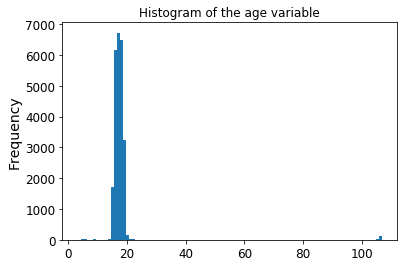

In [0]:
df['age'].plot.hist(
  bins = 100,
  title = "Histogram of the age variable"
)

C:\Users\lavet\Anaconda3\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\lavet\Anaconda3\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\lavet\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\lavet\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


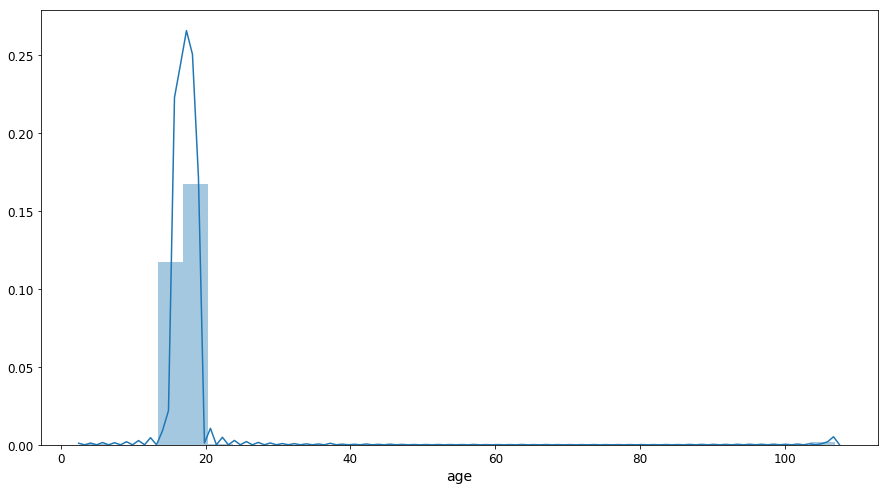

In [0]:
plt.figure(figsize=(15,8))
sns.distplot(df.age, bins =30)

,Total,Percent
age,5086,0.169533
gender,2724,0.090800
drugs,0,0.000000
cheerleading,0,0.000000
hot,0,0.000000


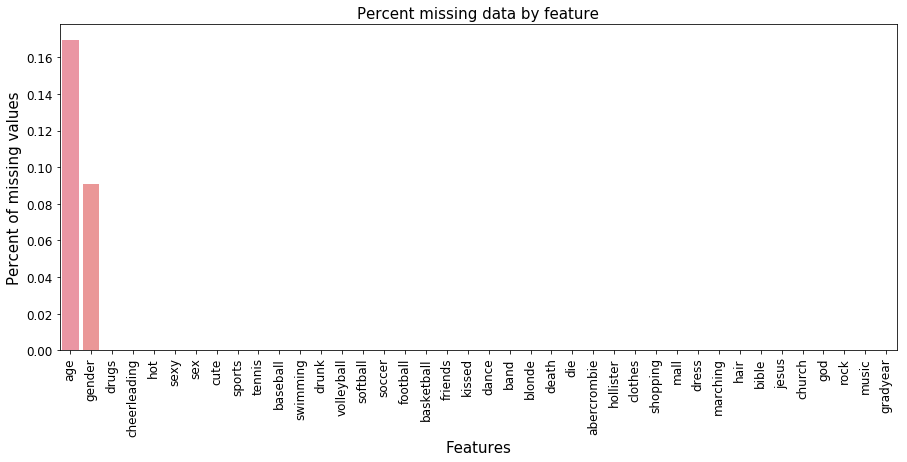

In [0]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
missing_data.head()

#### 2.3 Remove unnecessary columns, which we should not use in clustering

In [0]:
df.columns

Index(['gradyear', 'gender', 'age', 'friends', 'basketball', 'football',
       'soccer', 'softball', 'volleyball', 'swimming', 'cheerleading',
       'baseball', 'tennis', 'sports', 'cute', 'sex', 'sexy', 'hot', 'kissed',
       'dance', 'band', 'marching', 'music', 'rock', 'god', 'church', 'jesus',
       'bible', 'hair', 'dress', 'blonde', 'mall', 'shopping', 'clothes',
       'hollister', 'abercrombie', 'die', 'death', 'drunk', 'drugs'],
      dtype='object')

In [0]:
df = df.drop(['gradyear', 'gender', 'age'], axis=1)

In [0]:
# Keep the copy of original data frame
df_orig = df

#### 2.4 Normalize the data

In [0]:
def standardization(dataset):
    """ Standardization of numeric fields, where all values will have mean of zero 
    and standard deviation of one. (z-score)
    
    Args:
    dataset: A `Pandas.Dataframe` 
    """
    dtypes = list(zip(dataset.dtypes.index, map(str, dataset.dtypes)))
    #print(dtypes)
    # Normalize numeric columns.
    for column, dtype in dtypes:
        #if dtype == 'float32':
        dataset[column] -= dataset[column].mean()
        dataset[column] /= dataset[column].std()
    return dataset
df = standardization(df_orig)

In [0]:
df.head()

,friends,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,-0.643453,-0.338533,-0.365324,-0.245781,-0.222231,-0.224703,-0.263238,-0.209202,-0.204944,-0.170849,...,-0.05055,-0.373074,-0.495173,-0.318116,-0.201667,-0.184862,-0.304318,-0.264517,-0.223601,-0.177765
1,-0.834445,-0.338533,1.025018,-0.245781,-0.222231,-0.224703,-0.263238,-0.209202,-0.204944,-0.170849,...,-0.05055,1.053530,-0.495173,-0.318116,-0.201667,-0.184862,-0.304318,-0.264517,-0.223601,-0.177765
2,1.048195,-0.338533,1.025018,-0.245781,-0.222231,-0.224703,-0.263238,-0.209202,-0.204944,-0.170849,...,-0.05055,-0.373074,-0.495173,-0.318116,-0.201667,-0.184862,-0.304318,1.965769,-0.223601,-0.177765
3,-0.834445,-0.338533,-0.365324,-0.245781,-0.222231,-0.224703,-0.263238,-0.209202,-0.204944,-0.170849,...,-0.05055,-0.373074,-0.495173,-0.318116,-0.201667,-0.184862,-0.304318,-0.264517,-0.223601,-0.177765
5,3.039972,-0.338533,-0.365324,-0.245781,-0.222231,-0.224703,-0.263238,-0.209202,-0.204944,-0.170849,...,-0.05055,-0.373074,0.869380,-0.318116,-0.201667,-0.184862,-0.304318,-0.264517,2.244607,-0.177765


### 2 (B) Clsuter Tendency Aalysis
- Before clustering a dataset we can test if there are actually clusters
- We have to test the hypothesis of the existence of patterns in the data versus a dataset uniformly distributed (homogeneous distribution)

#### Methods: 
- Hopkins Statistic
- Visual Analysis Technique

#### 2b.1 Hopkins Statistic

In [0]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn import datasets

from scipy.spatial import distance_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
# Very time consuming...Can any one optimize it or paralleize?

def hopkins(x, n):
    """Hopkins Statistic
       Measures the cluster tendency of a data set.  Returns the statistic value.

       Parameters
       ----------
       x : array-like or sparse matrix, shape (n_samples, n_features). The data set

       n : int, number of points to sample randomly from the data set

    """

    d = len(x)
    columns = x.shape[1]

    for i in range(columns):
        if np.max(x[:, i]) == np.min(x[:, i]) == 0:
            pass
        else:
            x[:, i] = (x[:, i] - np.min(x[:, i])) / (np.max(x[:, i]) - np.min(x[:, i]))

    s = np.random.choice(d, n, replace=False)
    nns = NearestNeighbors(n_neighbors=1).fit(x)

    u, w = 0, 0
    for i in s:
        ran_point = [np.random.uniform(size=columns)]
        u += nns.kneighbors(ran_point)[0][0][0]
        w += nns.kneighbors([x[i]], 2)[0][0][1]

    return u / (u + w)

In [0]:
# hopkins method requires the data as a numpy array
# Convert the data frame to a numpy array
# df_npy.shape[0] - Number of samples (rows) in the data set

df_npy = df.to_numpy(copy=True)
hs = hopkins(df_npy, df_npy.shape[0])

# print Hopkins statistic
print(hs)

0.9751492319068206


### 3. Apply K-Means

#### 3.1 Fit and Predict

In [0]:
from sklearn.cluster import KMeans

In [0]:
kmeans = KMeans(n_clusters=5, random_state=42)
y_pred = kmeans.fit_predict(df)

Each instance was assigned to one of the 5 clusters:

In [0]:
y_pred

array([4, 3, 4, ..., 4, 4, 4])

In [0]:
y_pred is kmeans.labels_

True

And the following 5 _centroids_ (i.e., cluster centers) were estimated:

In [0]:
# kmeans.cluster_centers_

Note that the `KMeans` instance preserves the labels of the instances it was trained on. Somewhat confusingly, in this context, the _label_ of an instance is the index of the cluster that instance gets assigned to:

In [0]:
kmeans.labels_

array([4, 3, 4, ..., 4, 4, 4])

#### 3.2 predict the labels of new instances:

In [0]:
test = df.iloc[1:5,:]
kmeans.predict(test)

array([3, 4, 4, 4])

### 4. Decision Boundaries - Cluster Visualization

Plot based on random attributes with cluster IDs...

In [0]:
labels = kmeans.fit_predict(df)

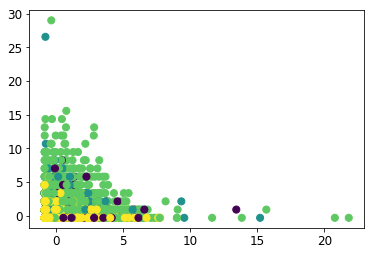

In [0]:
# Plot the clusters with first two attributes - clusters are not clear - use better method
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=labels,
            s=50, cmap='viridis');

Let's plot the model's two principal components and the centroids:

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pcs = pca.fit_transform(df)

In [0]:
pcs.shape

(27276, 2)

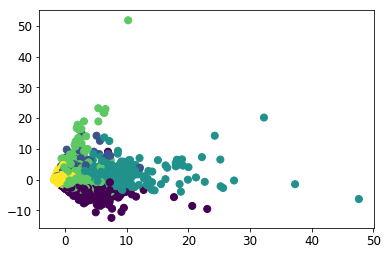

In [0]:
plt.scatter(pcs[:, 0], pcs[:, 1], c=labels,
            s=50, cmap='viridis');

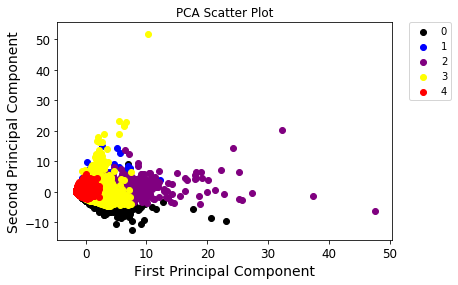

In [0]:
# Different approach to plot the clusters
colors = ['black', 'blue', 'purple', 'yellow', 'red', 'lime', 'cyan', 'orange', 'gray']
clus_ids = np.unique(labels)

k = 5
for i in range(k):
    x = pcs[:, 0][labels == i]
    y = pcs[:, 1][labels == i]
    plt.scatter(x, y, c=colors[i])
plt.legend(clus_ids, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title("PCA Scatter Plot")
plt.show()

### K-Means Variability

### Inertia

To select the best model, we will need a way to evaluate a K-Mean model's performance. Unfortunately, clustering is an unsupervised task, so we do not have the targets. But at least we can measure the distance between each instance and its centroid. This is the idea behind the _inertia_ metric:

In [0]:
kmeans.inertia_

884389.3499174347

As you can easily verify, inertia is the sum of the squared distances between each training instance and its closest centroid:

### Multiple Initializations

So one approach to solve the variability issue is to simply run the K-Means algorithm multiple times with different random initializations, and select the solution that minimizes the inertia. For example, here are the inertias of the two "bad" models shown in the previous figure:

When you set the `n_init` hyperparameter, Scikit-Learn runs the original algorithm `n_init` times, and selects the solution that minimizes the inertia. By default, Scikit-Learn sets `n_init=10`.

In [0]:
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                              algorithm="full", random_state=11)
kmeans_rnd_10_inits.fit(df)

KMeans(algorithm='full', copy_x=True, init='random', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=11, tol=0.0001, verbose=0)

### TODO - USe K-Means++ for initialization and observe the results

Instead of initializing the centroids entirely randomly, it is preferable to initialize them using the following algorithm, proposed in a [2006 paper](https://goo.gl/eNUPw6) by David Arthur and Sergei Vassilvitskii:
* Take one centroid $c_1$, chosen uniformly at random from the dataset.
* Take a new center $c_i$, choosing an instance $\mathbf{x}_i$ with probability: $D(\mathbf{x}_i)^2$ / $\sum\limits_{j=1}^{m}{D(\mathbf{x}_j)}^2$ where $D(\mathbf{x}_i)$ is the distance between the instance $\mathbf{x}_i$ and the closest centroid that was already chosen. This probability distribution ensures that instances that are further away from already chosen centroids are much more likely be selected as centroids.
* Repeat the previous step until all $k$ centroids have been chosen.

The rest of the K-Means++ algorithm is just regular K-Means. With this initialization, the K-Means algorithm is much less likely to converge to a suboptimal solution, so it is possible to reduce `n_init` considerably. Most of the time, this largely compensates for the additional complexity of the initialization process.

To set the initialization to K-Means++, simply set `init="k-means++"` (this is actually the default):

In [0]:
KMeans()

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

### How to speedup clustering? - Accelerated K-Means

The K-Means algorithm can be significantly accelerated by avoiding many unnecessary distance calculations: this is achieved by exploiting the triangle inequality (given three points A, B and C, the distance AC is always such that AC ≤ AB + BC) and by keeping track of lower and upper bounds for distances between instances and centroids (see this [2003 paper](https://www.aaai.org/Papers/ICML/2003/ICML03-022.pdf) by Charles Elkan for more details).

To use Elkan's variant of K-Means, just set `algorithm="elkan"`. Note that it does not support sparse data, so by default, Scikit-Learn uses `"elkan"` for dense data, and `"full"` (the regular K-Means algorithm) for sparse data.

In [0]:
%timeit KMeans(algorithm="elkan").fit(df)

4.24 s ± 236 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [0]:
%timeit KMeans(algorithm="full").fit(df)

2.18 s ± 226 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### EXERCISE - Which one is accuate?  elkan or full?

### EXERCISE - Finding the optimal number of clusters - K
- Using Inertia
- Using BIC
- Using AIC
- Using Silhouette score

What if the number of clusters was set to a lower or greater value than 5?
How inertia changes as we inrease K?

In [0]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k3.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [0]:
kmeans_k8 = KMeans(n_clusters=8, random_state=42)
kmeans_k8.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

Ouch, these two models don't look great. What about their inertias?

In [0]:
kmeans_k3.inertia_

9033682.937035345

In [0]:
kmeans_k8.inertia_

2084086.9007630532

No, we cannot simply take the value of $k$ that minimizes the inertia, since it keeps getting lower as we increase $k$. Indeed, the more clusters there are, the closer each instance will be to its closest centroid, and therefore the lower the inertia will be. However, we can plot the inertia as a function of $k$ and analyze the resulting curve:

In [0]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

### EXERCISE
Find out best K and repeat modeling and visualization